# Main Model

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

class DataLoader:
    def __init__(self, data_path, adj_datapath, start_day, n_training, n_timesteps, n_pred, day_start, day_end, airport_list):
        """
        :param data_path: path to the data file e.g. 'save.csv'
        :param start_day: the first day of the training data
        :param n_training: the number of days of the training data
        :param n_timesteps: the number of days of the input sequence
        :param n_pred: the number of days of the prediction
        :param day_start: the start day of the prediction
        :param day_end: the end day of the prediction
        """
        self.x = pd.read_csv(data_path).to_numpy()
        self.adj_datapath = adj_datapath
        self.start_day = start_day
        self.n_timesteps = n_timesteps
        self.n_training = n_training
        self.n_pred = n_pred
        self.day_start = day_start
        self.day_end = day_end
        self.n_batch = n_training-n_timesteps-n_pred
        self.airport_list = airport_list

    def concat_raw_data(self):
        # Concatenate all data in the folder: data_for_adjc_20230414updated into one file
        # List of the CSV file names
        """
        :return: a DataFrame that contains the number of flights between each pair of airports
        """
        csv_files = ['jan2020.csv', 'feb2020.csv', 'mar2020.csv', 'apr2020.csv', 'may2020.csv',
                     'jun2020.csv', 'jul2020.csv', 'aug2020.csv', 'sep2020.csv', 'oct2020.csv',
                     'nov2020.csv', 'dec2020.csv']
        # Read each CSV file into a DataFrame and store them in a list
        dataframes = [pd.read_csv(os.path.join(self.adj_datapath, file))[['Departure','Arrival','Date']].iloc[:-5] for file in csv_files]
        # Concatenate DataFrames column-wise (axis=1)
        combined_dataframe = pd.concat(dataframes, axis=0)
        combined_dataframe['Date'] = pd.to_datetime(combined_dataframe['Date'], format='%m/%d/%Y')
        combined_dataframe['Day_of_Year'] = combined_dataframe['Date'].dt.dayofyear
        # Sort the DataFrame by Date
        df = combined_dataframe.sort_values(by='Date').reset_index(drop=True)
        return df

    def count_total_flights(self):
        # Create a DataFrame that contains the number of flights between each pair of airports
        df = self.concat_raw_data()
        df = df.groupby(['Departure','Arrival']).size().reset_index(name='Flights')
        # Create a DataFrame that contains the number of flights from each airport
        df_departure = df.groupby('Departure').size().reset_index(name='Departure_Flights')
        # Create a DataFrame that contains the number of flights to each airport
        df_arrival = df.groupby('Arrival').size().reset_index(name='Arrival_Flights')
        # Merge the two DataFrames
        df = pd.merge(df, df_departure, on='Departure')
        df = pd.merge(df, df_arrival, on='Arrival')
        return df

    def creat_adjacency_matrix(self, df, timesteps_i):
        # Create adjacency matrix grouped by every 28 days
        df1 = df[(df['Day_of_Year'] <= self.day_end) & (df['Day_of_Year'] >= self.day_start)]
        data4adj = df1[(df1['Day_of_Year'] <= self.start_day+timesteps_i+28) & (df1['Day_of_Year'] >= self.start_day+timesteps_i)]
        num_airports = len(self.airport_list)
        adjcc_matrix = np.zeros((num_airports, num_airports))
        for _, row in data4adj.iterrows():
            departure_index = self.airport_list.index(row['Departure'])
            arrival_index = self.airport_list.index(row['Arrival'])
            adjcc_matrix[departure_index, arrival_index] += 1
        scaler_adj = MinMaxScaler(feature_range=(0, 1))
        # Reshape the matrix to be treated as a whole
        matrix_reshaped = adjcc_matrix.reshape(-1, 1)
        normalized_matrix_reshaped = scaler_adj.fit_transform(matrix_reshaped)
        # Reshape the normalized matrix back to its original shape
        normalized_matrix = normalized_matrix_reshaped.reshape(adjcc_matrix.shape)
        return normalized_matrix

    def train_test_split(self, combined_data):
        self.train = self.x[:,self.start_day:self.start_day+self.n_training]
        self.scale = StandardScaler()
        self.train = self.scale.fit_transform(self.train.T).T
        self.x_train = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        self.y_train = np.zeros(shape=(self.n_batch, 77*self.n_pred))
        for i in range(self.n_batch):
            self.x_train[i,:,:] = self.train[:,i:i+self.n_timesteps].T
            self.y_train[i,:] = self.train[:,i+self.n_timesteps:i+self.n_timesteps+self.n_pred].flatten()
            xy_adj= self.creat_adjacency_matrix(df=combined_data, timesteps_i=i)
            # Multiply the adjacency matrix with the number of flights
            self.x_train[i,:,:] = self.x_train[i,:,:] @ xy_adj
            # Normalize x_train
            # self.x_train[i,:,:] = self.scale.transform(self.x_train[i,:,:])
            # self.y_train[i,:] = self.train[:,i+self.n_timesteps:i+self.n_timesteps+self.n_pred] @ xy_adj
            # self.y_train[i,:] = self.y_train[i,:].flatten()

        # +1 is added here to resolve the issue that the state of LSTM is 0 for the first element
        self.test = self.x[:,self.start_day+self.n_pred+1:]
        self.test = self.scale.transform(self.test.T).T
        self.x_test = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        for i in range(self.n_batch):
            self.x_test[i,:,:] = self.test[:,i:i+self.n_timesteps].T
            self.x_test[i,:,:] = self.x_test[i,:,:] @ xy_adj
        return tf.convert_to_tensor(self.x_train), tf.convert_to_tensor(self.y_train), tf.convert_to_tensor(self.x_test), xy_adj

# x = pd.read_csv('save.csv').to_numpy()
# scaler = StandardScaler()
# x = scaler.fit_transform(x.T).T

# n_batch = 64
# n_timesteps = 40
# n_pred = 3
# nn_input = np.zeros(shape=(n_batch, n_timesteps, 77))
# nn_output = np.zeros(shape=(n_batch, 77*n_pred))
# for i in range(n_batch):
#     nn_input[i,:,:] = x[:,i:i+n_timesteps].T
#     nn_output[i,:] = x[:,i+n_timesteps:i+n_timesteps+n_pred].flatten()

# nn_input = tf.convert_to_tensor(nn_input)
# nn_output = tf.convert_to_tensor(nn_output)
# # Prepare the output data
# num_output = 77 * n_pred

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(num_output, batch_input_shape=(n_batch,n_timesteps,77)))
# model.add(Dense(num_output//2, activation='relu'))
# model.add(Dense(num_output, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(nn_input, nn_output, epochs=100, batch_size=32)


In [12]:
adj_path = os.path.join('..', 'dataset', 'data_for_adjc_20230414updated')
airport_code_list = ['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF', 'BUR', 'BWI',
                     'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN', 'DFW', 'DTW', 'EWR', 'FLL', 'GYY',
                     'HNL', 'HOU', 'HPN', 'IAD', 'IAH', 'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB',
                     'MCI', 'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK', 'OGG', 'OMA', 'ONT', 'ORD', 'OXR',
                     'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW',
                     'SAN', 'SAT', 'SDF', 'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'SWF',
                     'TEB', 'TPA', 'TUS', 'VNY']
forecast_day_range_start = 1   # From day-1 to day-121
forecast_day_range_end = 366
loader = DataLoader('2020.csv', adj_path,
                    start_day=150,
                    n_training=28*2,
                    n_timesteps=21,
                    n_pred=7,
                    day_start=forecast_day_range_start,
                    day_end=forecast_day_range_end,
                    airport_list=airport_code_list)

combined_df = loader.concat_raw_data()
x_train, y_train, x_test, adjacency = loader.train_test_split(combined_df)

2023-04-19 17:23:45.093085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
model = Sequential()
model.add(LSTM(loader.n_pred*77, batch_input_shape=(loader.n_batch,loader.n_timesteps,77)))
model.add(Dense(loader.n_pred*77//2, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(loader.n_pred*77, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=7)

Epoch 1/100
4/4 [==============================] - 1s 30ms/step - loss: 0.8559
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.6052
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.4485
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 0.3780
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.3402
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.3257
Epoch 7/100
4/4 [==============================] - 0s 44ms/step - loss: 0.3014
Epoch 8/100
4/4 [==============================] - 0s 30ms/step - loss: 0.2929
Epoch 9/100
4/4 [==============================] - 0s 32ms/step - loss: 0.2784
Epoch 10/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2667
Epoch 11/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2580
Epoch 12/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2484
Epoch 13/100
4/4 [==============================]

1/1 [==============================] - 0s 224ms/step


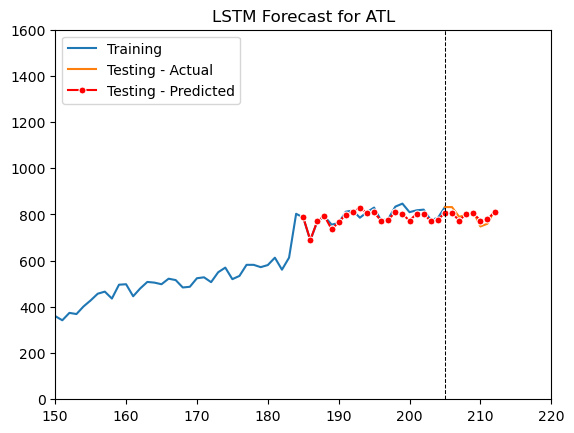

In [31]:
predicted = model.predict(x_test)
result = LSTMoutput(loader, 2)
result.inverse_transform(predicted)
result.plot()

### affect controller staffing, ground serice vehicles, driver, revenue from landing fees

In [14]:
class LSTMoutput:
    def __init__(self, DataLoader, airport_index):
        self.actual = DataLoader.x
        self.n_timesteps = DataLoader.n_timesteps
        self.scale = DataLoader.scale
        self.airport_index = airport_index

        self.n_batch = DataLoader.n_batch
        self.n_training = DataLoader.n_training
        self.n_pred = DataLoader.n_pred
        self.start_day = DataLoader.start_day

    def inverse_transform(self, input):
        self.predicted_transformed = self.scale.inverse_transform(input[-1,:].reshape(77,self.n_pred).T).T[self.airport_index,:]

        self.predicted_transformed = []
        for i in range(self.n_batch):
            traffic = self.scale.inverse_transform(input[i,:].reshape(77,self.n_pred).T).T[self.airport_index, self.n_pred-1]
            self.predicted_transformed.append(traffic)

    def plot(self):
        x_train_start = self.start_day
        y_train_start = self.start_day
        x_train_end = x_train_start + self.n_training
        y_train_end = y_train_start + self.n_training

        x_test_start = self.start_day+self.n_training-1
        x_test_end = x_test_start+self.n_pred+1
        y_test_start = self.start_day+self.n_training-1
        y_test_end = x_test_start+self.n_pred+1

        x_forecast_start = 2*self.n_pred+self.start_day+self.n_timesteps
        x_forecast_end = x_forecast_start + self.n_batch
        
        fig, ax = plt.subplots()
        sns.lineplot(x=np.arange(x_train_start, x_train_end), 
                     y=self.actual[self.airport_index, np.arange(y_train_start, y_train_end)], 
                     label='Training',
                     ax=ax)
        sns.lineplot(x=np.arange(x_test_start, x_test_end), 
                     y=self.actual[self.airport_index, np.arange(y_test_start, y_test_end)], 
                     label='Testing - Actual',
                     ax=ax)
        sns.lineplot(x=np.arange(x_forecast_start, x_forecast_end), 
                     y=self.predicted_transformed, 
                     color='red', 
                     marker='o', 
                     ms=5, 
                     label='Testing - Predicted',
                     ax=ax)
        ax.set(title='LSTM Forecast for ATL',
               ylim=(0,1600), 
               xlim=(x_train_start, x_forecast_end+7))
        plt.axvline(x=x_train_end-1, color='black', linestyle='--', linewidth=0.75)
        plt.legend()

        # padded = np.pad(np.array(self.pred_transformed), (self.n_timesteps, 0))
        # self.padded = padded
        # value = np.append(padded, actual)
        # self.value = value
        # day = np.tile(np.arange(1, self.n_timesteps+self.n_batch+1), (2))
        # type = np.concatenate((np.array(['Predicted']*(self.n_timesteps+self.n_batch)), np.array(['Actual']*(self.n_timesteps+self.n_batch))))
        # atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
        # atl_plot.columns = ['Value', 'Day', 'Type']
        # atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
        # ax.set(title='ATL Throughput - Training Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')

1/1 [==============================] - 0s 42ms/step


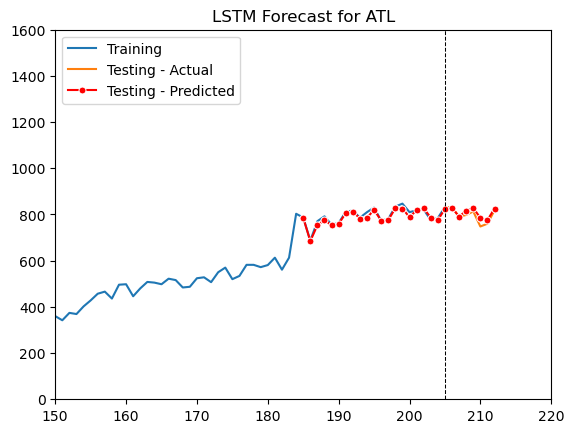

In [16]:
predicted = model.predict(x_test)
result = LSTMoutput(loader, 2)
result.inverse_transform(predicted)
result.plot()

In [ ]:
def adjacancy(df, return_graph=False):
    df2 = df.groupby(['departure','arrival']).sum('number_of_flights').reset_index()
    df2.columns = ['departure', 'arrival', 'weight']

    g = nx.from_pandas_edgelist(df2, source='departure', target='arrival', edge_attr='weight' )
    a = nx.adjacency_matrix(g)
    # print(a.todense())

    if return_graph:
        return g
    else:

        return a.todense()

In [1]:

l = nx.laplacian_matrix(adj).todense()
L = nx.laplacian_matrix(G)
nL = csgraph.laplacian(l, normed=True)
degrees = dict(nx.degree(adj))
D = np.diag(list(degrees.values()))

A = nx.adjacency_matrix(adj)
A_dense = A.toarray()

normalized_gl = (D-A_dense)/2.19890275e+03

import numpy as np
from scipy.linalg import eigh
# compute the eigenvalues and eigenvectors of the Laplacian matrix
eps = 1e-8  # small positive constant
evals, evecs = eigh(normalized_gl, eigvals=(0, 76))




eigenvalues, eigenvectors = np.linalg.eigh(l)
sort_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:, sort_indices]

def conv_matrix(x, days=14):
    output = np.zeros(shape=(days, 77, 77))
    for i in range(days-1):
        output[i,:,:] = np.corrcoef(x[:, :i])
    return output
conv_matrix_input = conv_matrix(x_matrix)

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rc("figure", dpi=120)

loader = DataLoader('save.csv', 20, 28*2, 14, 7)
a,b,c,d = loader.train_test_split()

: 

: 

In [1481]:
check[4:6]

array([4, 5])

In [709]:
padded = np.pad(np.array(pred_transformed_atl), (40,0))
value = np.append(padded, x[2,:40+64])
day = np.tile(np.arange(1,105),(2))
type = np.concatenate((np.array(['Predicted']*104), np.array(['Actual']*104)))
atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
atl_plot.columns = ['Value', 'Day', 'Type']
atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 120 and the array at index 1 has size 208

[Text(0.5, 1.0, 'ATL Throughput - Training Results'),
 Text(0.5, 0, 'Days Since 1/1/20'),
 Text(0, 0.5, '# of Flights')]

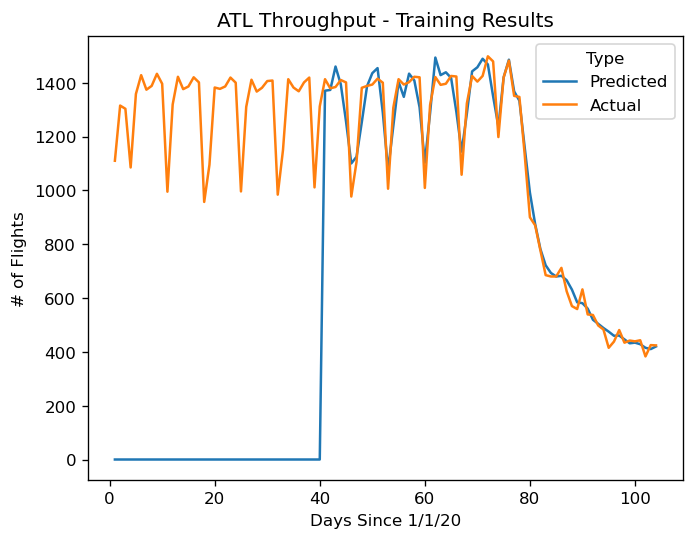

In [669]:
fig, ax = plt.subplots()
sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
ax.set(title='ATL Throughput - Training Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')

In [644]:
x = pd.read_csv('save.csv').to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
testing_input = np.zeros(shape=(n_batch, n_timesteps, 77))
for i in range(n_batch):
    testing_input[i,:,:] = x[:,i+17:i+17+n_timesteps].T

In [624]:
testing_results = model.predict(testing_input)

2/2 [==============================] - 0s 13ms/step


In [629]:
testing_atl = []
for i in range(64):
    a = LSTMoutput(40+17+i)
    traffic = a.inverse_transform(testing_results[i,:],0)[2,0]
    testing_atl.append(traffic)

In [631]:
x = pd.read_csv('save.csv').to_numpy()
padded = np.pad(np.array(testing_atl), (57,0))
value = np.append(padded, x[2,:57+64])
day = np.tile(np.arange(1,122),(2))
type = np.concatenate((np.array(['Predicted']*121), np.array(['Actual']*121)))
atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
atl_plot.columns = ['Value', 'Day', 'Type']
atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)

[Text(0.5, 1.0, 'ATL Throughput - Testing Results'),
 Text(0.5, 0, 'Days Since 1/1/20'),
 Text(0, 0.5, '# of Flights')]

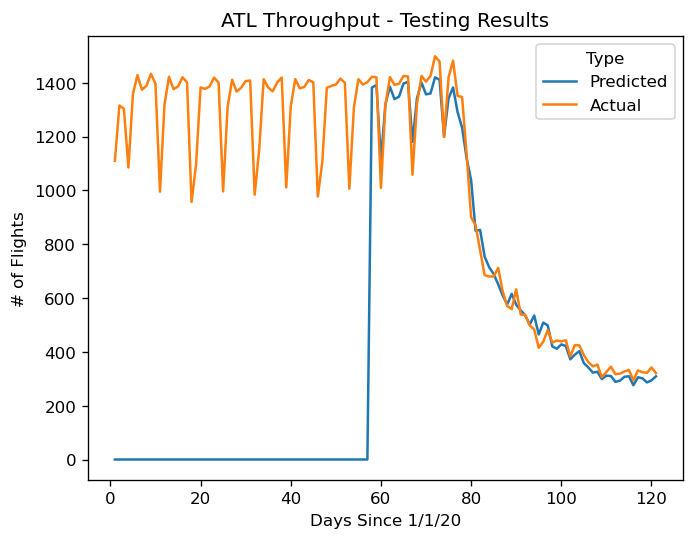

In [632]:
fig, ax = plt.subplots()
sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
ax.set(title='ATL Throughput - Testing Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')

In [36]:
adj_datapath = os.path.join('..', 'dataset', 'data_for_adjc_20230414updated')
csv_files = ['jan2020.csv', 'feb2020.csv', 'mar2020.csv', 'apr2020.csv', 'may2020.csv',
                     'jun2020.csv', 'jul2020.csv', 'aug2020.csv', 'sep2020.csv', 'oct2020.csv',
                     'nov2020.csv', 'dec2020.csv']
        # Read each CSV file into a DataFrame and store them in a list
dataframes = [pd.read_csv(os.path.join(adj_datapath, file))[['Departure','Arrival','Date','Flight\nCount']].iloc[:-5] for file in csv_files]
        # Concatenate DataFrames column-wise (axis=1)
combined_dataframe = pd.concat(dataframes, axis=0)
combined_dataframe['Date'] = pd.to_datetime(combined_dataframe['Date'], format='%m/%d/%Y')
combined_dataframe['Day_of_Year'] = combined_dataframe['Date'].dt.dayofyear
# Sort the DataFrame by Date
df = combined_dataframe.sort_values(by='Date').reset_index(drop=True)

In [39]:
df.to_csv('2020_adj.csv', index=False)